# ADZD Lab5 - GraphFrames
**Author: Bartłomiej Jamiołkowski**

## Libraries

In [1]:
from pyspark.sql import DataFrame
from pyspark.sql.types import IntegerType
from graphframes import graphframe
from graphframes.lib import Pregel
from pyspark.sql.functions import col, udf, when, coalesce, sum
from graphframes import GraphFrame
from pyspark.shell import spark
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.5.0
      /_/

Using Python version 3.11.6 (main, Oct  3 2023 10:40:35)
Spark context Web UI available at http://0630f9d3d4cf:4040
Spark context available as 'sc' (master = local[*], app id = local-1733774902171).
SparkSession available as 'spark'.


## Exercise 1
Load the Facebook graph, edges from the file musae_facebook_edges.csv and the attributes page_name and page_type from the file `musae_facebook_target.csv. Count the number of edges and vertices.

In [2]:
edges_df = spark.read.csv('./facebook_large/musae_facebook_edges.csv', header = True, inferSchema = True).toDF('src', 'dst')

In [3]:
edges_df.toPandas().head()

,src,dst
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829


In [4]:
vertices_df = spark.read.csv('./facebook_large/musae_facebook_target.csv', header = True, inferSchema = True)

In [5]:
vertices_df.toPandas().head()

,id,facebook_id,page_name,page_type
0,0,145647315578475,The Voice of China 中国好声音,tvshow
1,1,191483281412,U.S. Consulate General Mumbai,government
2,2,144761358898518,ESET,company
3,3,568700043198473,Consulate General of Switzerland in Montreal,government
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician


In [6]:
facebook_graph = graphframe.GraphFrame(vertices_df, edges_df)
print(facebook_graph)

GraphFrame(v:[id: int, facebook_id: bigint ... 2 more fields], e:[src: int, dst: int])


In [7]:
display(facebook_graph.edges.count()) 

171002

In [8]:
display(facebook_graph.vertices.count())

22470

## Exercise 2
Check if the graph is connected. Are the two subgraphs created for the page types 'governmental organizations' and 'television shows' also connected?

In [100]:
spark.sparkContext.setCheckpointDir('/tmp/graphframes-example-connected-components')
components = facebook_graph.connectedComponents()
components.toPandas().head()

,id,facebook_id,page_name,page_type,component
0,0,145647315578475,The Voice of China 中国好声音,tvshow,0
1,1,191483281412,U.S. Consulate General Mumbai,government,0
2,2,144761358898518,ESET,company,0
3,3,568700043198473,Consulate General of Switzerland in Montreal,government,0
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician,0


In [101]:
display(components.select('component').distinct().count())

1

Obtained value indicates that the graph is connected.

In [102]:
gov_org_subgraph = facebook_graph.filterVertices("page_type = 'government'").dropIsolatedVertices()

In [103]:
gov_org_subgraph.vertices.toPandas().head()

,id,facebook_id,page_name,page_type
0,1,191483281412,U.S. Consulate General Mumbai,government
1,3,568700043198473,Consulate General of Switzerland in Montreal,government
2,8,544818128942324,T.C. Mezar-ı Şerif Başkonsolosluğu,government
3,9,285155655705,Army ROTC Fighting Saints Battalion,government
4,10,295294787190810,NASA Student Launch,government


In [104]:
gov_org_components = gov_org_subgraph.connectedComponents()
gov_org_components.toPandas().head()

,id,facebook_id,page_name,page_type,component
0,1,191483281412,U.S. Consulate General Mumbai,government,1
1,3,568700043198473,Consulate General of Switzerland in Montreal,government,1
2,8,544818128942324,T.C. Mezar-ı Şerif Başkonsolosluğu,government,1
3,9,285155655705,Army ROTC Fighting Saints Battalion,government,1
4,10,295294787190810,NASA Student Launch,government,1


In [105]:
display(gov_org_components.select('component').distinct().count())

5

Obtained value differs from 1, so the subgraph created for page type 'governmental organizations' is not connected.

In [106]:
tv_shows_subgraph = facebook_graph.filterVertices("page_type = 'tvshow'").dropIsolatedVertices()

In [107]:
tv_shows_subgraph.vertices.toPandas().head()

,id,facebook_id,page_name,page_type
0,0,145647315578475,The Voice of China 中国好声音,tvshow
1,27,220206968012871,Poppy Cat,tvshow
2,44,1507698529534072,APB FOX,tvshow
3,52,1388741348032650,식샤를합시다,tvshow
4,55,141018599260302,Abendschau,tvshow


In [108]:
tv_shows_components = tv_shows_subgraph.connectedComponents()
tv_shows_components.toPandas().head()

,id,facebook_id,page_name,page_type,component
0,0,145647315578475,The Voice of China 中国好声音,tvshow,0
1,27,220206968012871,Poppy Cat,tvshow,0
2,44,1507698529534072,APB FOX,tvshow,0
3,52,1388741348032650,식샤를합시다,tvshow,0
4,55,141018599260302,Abendschau,tvshow,0


In [109]:
display(tv_shows_components.select('component').distinct().count())

26

Obtained value differs from 1, so the subgraph created for page type 'television shows' is not connected.

## Exercise 3
From the top 500 pages with the highest PageRank, find the 20 pages (list the page_name and page_type) with the fewest connections and the 20 with the most connections. Which page type was dominant in each of these categories? Plot a scatter plot showing the relationship between PageRank and the number of edges for the vertices.

In [110]:
pagerank_facebook = facebook_graph.pageRank(resetProbability = 0.15, maxIter = 10)

In [111]:
pagerank_facebook.vertices.toPandas().head()

,id,facebook_id,page_name,page_type,pagerank
0,20227,117455221614291,aspekte,tvshow,4.370687
1,15474,707703419357258,"India in Switzerland (Embassy of India, Berne)",government,0.375980
2,18624,244266119255283,Famous,tvshow,1.492679
3,7608,142237522483061,HLN News Now,tvshow,0.513228
4,9166,110108698921,Austin HSEM,government,0.537848


In [112]:
pagerank_facebook.edges.toPandas().head()

,src,dst,weight
0,0,18427,1.000000
1,1,2812,0.029412
2,1,4987,0.029412
3,1,5228,0.029412
4,1,5307,0.029412


In [113]:
pagerank_facebook_with_degrees = pagerank_facebook.vertices.join(facebook_graph.degrees, 'id')

In [114]:
pagerank_facebook_with_degrees.toPandas().head()

,id,facebook_id,page_name,page_type,pagerank,degree
0,20227,117455221614291,aspekte,tvshow,4.370687,10
1,15474,707703419357258,"India in Switzerland (Embassy of India, Berne)",government,0.375980,1
2,18624,244266119255283,Famous,tvshow,1.492679,58
3,7608,142237522483061,HLN News Now,tvshow,0.513228,6
4,9166,110108698921,Austin HSEM,government,0.537848,10


In [115]:
top_500_facebook_pages = pagerank_facebook_with_degrees.orderBy('pagerank', ascending = False).limit(500)

In [116]:
top_20_least_connected_facebook_pages = top_500_facebook_pages.orderBy('degree', ascending = True).limit(20).select('page_name', 'page_type')
display(top_20_least_connected_facebook_pages.toPandas())

,page_name,page_type
0,Kinder,company
1,adidas Women,company
2,spark7,company
3,Viessmann,company
4,Akris,company
5,Josi Nunes,politician
6,Jonathan Stickland,politician
7,Samsung Ukraine,company
8,Paiz Guatemala,company
9,Sour Jacks,company


In [117]:
display(top_20_least_connected_facebook_pages.groupBy('page_type').count().orderBy('count', ascending = False).toPandas())

,page_type,count
0,company,13
1,politician,6
2,tvshow,1


The 'company' page type was dominant in the 20 pages with the fewest connections.

In [118]:
top_20_most_connected_facebook_pages = top_500_facebook_pages.orderBy('degree', ascending = False).limit(20).select('page_name', 'page_type')
display(top_20_most_connected_facebook_pages.toPandas())

,page_name,page_type
0,U.S. Army,government
1,The White House,government
2,The Obama White House,government
3,U.S. Army Chaplain Corps,government
4,U.S. Department of State,government
5,FEMA Federal Emergency Management Agency,government
6,European Parliament,government
7,United States Air Force,government
8,"Los Angeles District, U.S. Army Corps of Engin...",government
9,Barack Obama,politician


In [119]:
display(top_20_most_connected_facebook_pages.groupBy('page_type').count().orderBy('count', ascending = False).toPandas())

,page_type,count
0,government,17
1,politician,3


The 'government' page type was dominant in the 20 pages with the most connections.

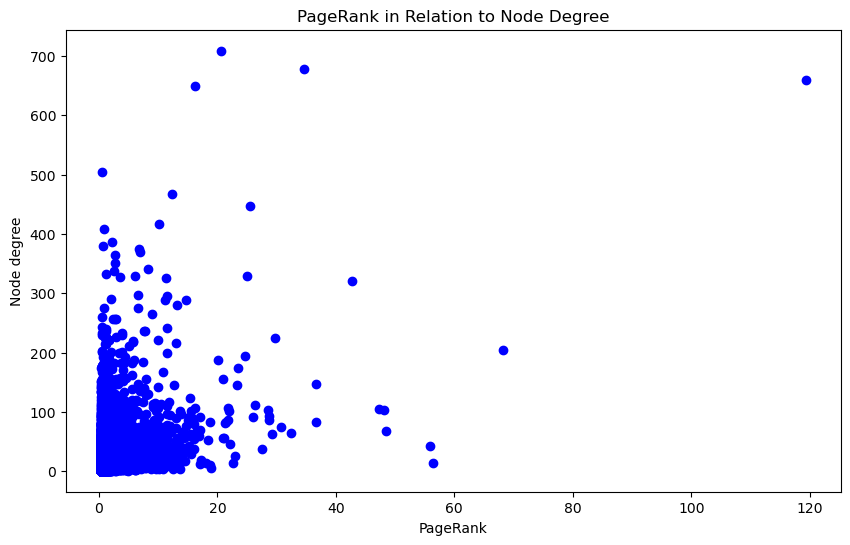

In [121]:
plt.figure(figsize = (10, 6))
plt.scatter(pagerank_facebook_with_degrees.toPandas()['pagerank'], pagerank_facebook_with_degrees.toPandas()['degree'], color = 'blue')
plt.title('PageRank in Relation to Node Degree')
plt.xlabel('PageRank')
plt.ylabel('Node degree')
plt.show()

## Exercise 4
Using the Pregel API, implement the following algorithm. In the first step, a selected page publishes a fake news post. In the next step, this post is published by 1/3 of the randomly selected contacts of this page. In subsequent steps, for each page that has already published the post, 1/3 of its randomly selected contacts publish it as well. Show how the number of pages that have published the post changes depending on the number of steps. Optional: Check the above relationship for a factor other than 1/4.

In [9]:
vertices_df.filter(col('id') == '12756').collect()
spark.sparkContext.setCheckpointDir('checkpoints')

def reposted(seen_fake_news, p):
    return random.random() < 1 - (1 - p) ** seen_fake_news

reposted_udf = udf(reposted, 'boolean')

def calculate_publisher_number(graph, maxIter, p):
    count = 1
    
    while count <= 1:
        result = graph.pregel \
            .setMaxIter(maxIter) \
            .withVertexColumn(
                'posted',
                when(col('id') == '12756', True).otherwise(False),
                coalesce(Pregel.msg() | col('posted'), col('posted'))
            ) \
            .sendMsgToSrc(
                Pregel.dst('posted')
            ) \
            .aggMsgs(
                reposted(
                    sum(Pregel.msg().cast('int')),
                    p
                )
            ) \
            .run()

        count = result.filter(col('posted') == True).count()

    return count

In [10]:
fake_news_1_3_dict = {max_iter: calculate_publisher_number(facebook_graph, max_iter, 1/3) for max_iter in tqdm(list(range(1, 15)))}
fake_news_1_3_df = pd.DataFrame(list(fake_news_1_3_dict.items()), columns = ['max_iterations', 'publishers_count'])

100%|██████████| 14/14 [04:26<00:00, 19.04s/it]


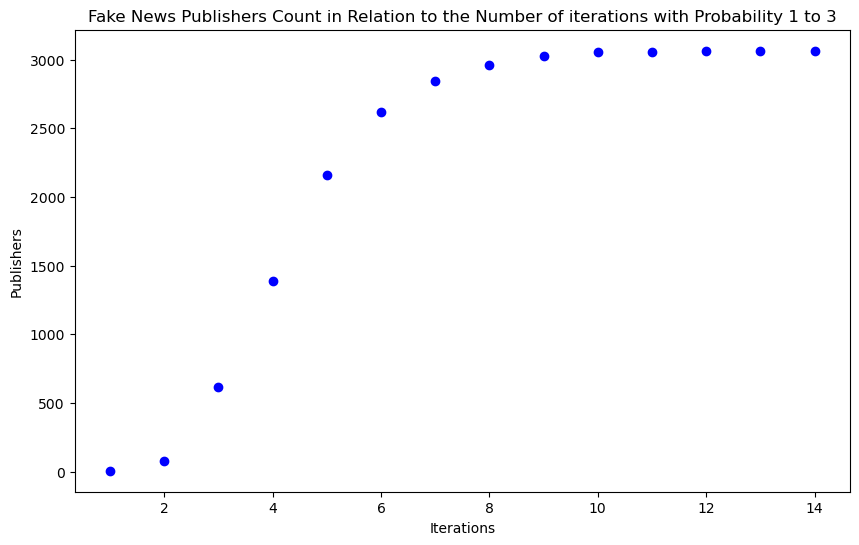

In [13]:
plt.figure(figsize = (10, 6))
plt.scatter(fake_news_1_3_df['max_iterations'], fake_news_1_3_df['publishers_count'], c = 'blue')
plt.title('Fake News Publishers Count in Relation to the Number of iterations with Probability 1 to 3')
plt.xlabel('Iterations')
plt.ylabel('Publishers')
plt.show()

In [10]:
fake_news_1_5_dict = {max_iter: calculate_publisher_number(facebook_graph, max_iter, 1/5) for max_iter in tqdm(list(range(1, 15)))}
fake_news_1_5_df = pd.DataFrame(list(fake_news_1_5_dict.items()), columns = ['max_iterations', 'publishers_count'])

100%|██████████| 14/14 [07:09<00:00, 30.67s/it]


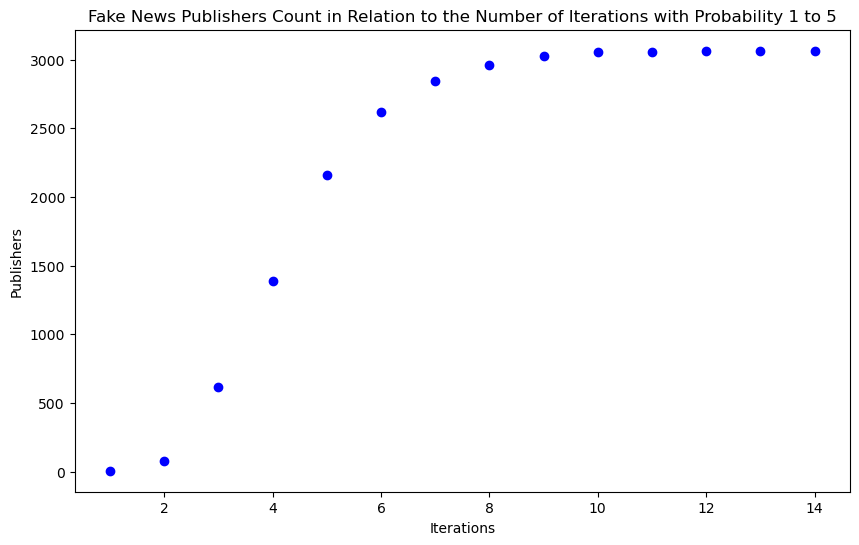

In [11]:
plt.figure(figsize = (10, 6))
plt.scatter(fake_news_1_5_df['max_iterations'], fake_news_1_5_df['publishers_count'], c = 'blue')
plt.title('Fake News Publishers Count in Relation to the Number of Iterations with Probability 1 to 5')
plt.xlabel('Iterations')
plt.ylabel('Publishers')
plt.show()

## Exercise 5
Plot the degree distribution of the vertices in the graph on a logarithmic scale. You can use the function stat.approxQuantile. Is the network scale-free https://barabasi.com/media/pub_imports/files/623.pdf ?

In [151]:
degrees = facebook_graph.degrees.select('degree').rdd.map(lambda g: g['degree']).collect()
degree_hist = np.histogram(degrees, bins = range(1, np.max(degrees)))
log_bins = np.log(degree_hist[1][:-1])
log_counts = np.log(degree_hist[0] + 1)

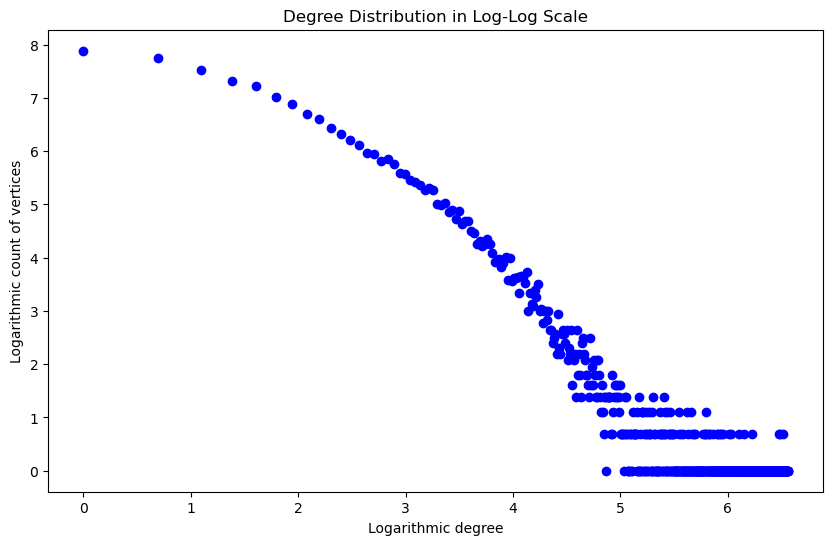

In [154]:
plt.figure(figsize = (10, 6))
plt.scatter(log_bins, log_counts, color='blue')
plt.title('Degree Distribution in Log-Log Scale')
plt.xlabel('Logarithmic degree')
plt.ylabel('Logarithmic count of vertices')
plt.show()

By comparing the log-log plot with the information available in the linked file, I can confirm that the network is not scale-free. This conclusion is supported by the fact that the plot does not form a straight line. Additionally, there is low-degree saturation and a high-degree cutoff.